In [1]:
!unzip '/content/drive/MyDrive/Colab Notebooks/CAPTCHA Images.zip' -d CAPTCHA

Archive:  /content/drive/MyDrive/Colab Notebooks/CAPTCHA Images.zip
  inflating: CAPTCHA/samples/226md.png  
  inflating: CAPTCHA/samples/22d5n.png  
  inflating: CAPTCHA/samples/2356g.png  
  inflating: CAPTCHA/samples/23mdg.png  
  inflating: CAPTCHA/samples/23n88.png  
  inflating: CAPTCHA/samples/243mm.png  
  inflating: CAPTCHA/samples/244e2.png  
  inflating: CAPTCHA/samples/245y5.png  
  inflating: CAPTCHA/samples/24f6w.png  
  inflating: CAPTCHA/samples/24pew.png  
  inflating: CAPTCHA/samples/25257.png  
  inflating: CAPTCHA/samples/253dc.png  
  inflating: CAPTCHA/samples/25egp.png  
  inflating: CAPTCHA/samples/25m6p.png  
  inflating: CAPTCHA/samples/25p2m.png  
  inflating: CAPTCHA/samples/25w53.png  
  inflating: CAPTCHA/samples/264m5.png  
  inflating: CAPTCHA/samples/268g2.png  
  inflating: CAPTCHA/samples/28348.png  
  inflating: CAPTCHA/samples/28x47.png  
  inflating: CAPTCHA/samples/2b827.png  
  inflating: CAPTCHA/samples/2bg48.png  
  inflating: CAPTCHA/samples/2

In [2]:
# 데이터 확인

In [3]:
import matplotlib.pyplot as plt
import glob

imgfile = glob.glob('/content/CAPTCHA/samples/*.png')
imgfile[:5]

['/content/CAPTCHA/samples/xe6eb.png',
 '/content/CAPTCHA/samples/ppwyd.png',
 '/content/CAPTCHA/samples/d7nn3.png',
 '/content/CAPTCHA/samples/7cdge.png',
 '/content/CAPTCHA/samples/7nnnx.png']

(50, 200, 4)


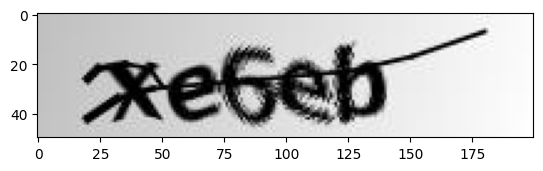

In [4]:
from PIL import Image
import numpy as np
img = Image.open(imgfile[0])
print(np.array (img).shape)
plt.imshow(img)
plt.show()

학습용 데이터 셋

In [5]:
# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
  # 공백 문자 <pad>를 0으로 설정
  BOW = { '<pad>':0}
  for letter in corpus:
    if letter not in BOW.keys():
      BOW[letter] = len(BOW.keys())
  return BOW

In [6]:
import numpy as np

from torch.utils.data.dataset import Dataset
import string

# 문자들로부터 BOW를 만드는 함수
def get_BOW(corpus):
   # 공백문자 <pad>를 0으로 설정
   BOW = {"<pad>":0}

   # corpus의 문자들을 이용해 BOW에 고유번호 추가
   for letter in corpus:
       if letter not in BOW.keys():
           BOW[letter] = len(BOW.keys())

   return BOW


class Captcha(Dataset):
   def __init__(self, pth, train=True):
       # 소문자와 숫자만 정답으로 이용
       self.corpus = string.ascii_lowercase + string.digits
       self.BOW = get_BOW(self.corpus)

       # 불러올 이미지 파일의 경로
       self.imgfiles = glob.glob(pth+"/*.png")

       self.train = train
       self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
       self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]

   # 문자와 숫자를 고유번호로 치환
   def get_seq(self, line):
       label = []

       for letter in line:
           label.append(self.BOW[letter])

       return label

   def __len__(self):
       if self.train:
           return len(self.trainset)
       else:
           return len(self.testset)

   def __getitem__(self, i):
       if self.train:
           # png파일을 RGB파일로 변환
           data = Image.open(self.trainset[i]).convert("RGB")

           label = self.trainset[i].split("/")[-1]
           # 파일이름에서 확장자를 제거
           label = label.split(".png")[0]
           # 정답 문자열을 BOW의 순열로 변환
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           # 파이토치는 채널이 가장 앞에 와야 함
           data = np.transpose(data, (2, 0, 1))
           label = np.array(label)

           return data, label

       else:
           data = Image.open(self.testset[i]).convert("RGB")
           label = self.testset[i].split("/")[-1]
           label = label.split(".png")[0]
           label = self.get_seq(label)

           data = np.array(data).astype(np.float32)
           label = np.array(label)

           return data, label

In [7]:
# CNN - ResNet
# 커널 모양이 다르다ㅏ
import torch
import torch.nn as nn

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3X5 크기의 커널을 이용
class BasicBlock(nn.Module):
   def __init__(self,
                in_channels,
                out_channels,
                kernel_size=(3, 5),
                stride=(2, 1)):
       super(BasicBlock, self).__init__()

       self.c1 = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels,
                           kernel_size=kernel_size,
                           stride=stride)
       self.c2 = nn.Conv2d(in_channels=out_channels,
                           out_channels=out_channels,
                           kernel_size=(3, 3), padding=1)

       self.downsample = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride)

       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()

   def forward(self, x):
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       x_ = self.downsample(x_)

       x += x_
       x = self.relu(x)

       return x

H : $ \text{height} = \left\lfloor \frac{H - K_h}{S_h} + 1 \right\rfloor
$
W : $\text{width} = \left\lfloor \frac{W - K_w}{S_w} + 1 \right\rfloor $

In [9]:
# (50,200,4)
# 커널의 높이는 3 너비는 5
# 스트라이드의 높이는 2 너비는 1
# H : 3    W :

import torch.nn.functional as F
class CRNN(nn.Module):
   def __init__(self, output_size):
       super(CRNN, self).__init__()

       # CNN층의 정의
       self.c1 = BasicBlock(in_channels=3, out_channels=64)
       self.c2 = BasicBlock(in_channels=64, out_channels=64)
       self.c3 = BasicBlock(in_channels=64, out_channels=64)
       self.c4 = BasicBlock(in_channels=64, out_channels=64)
       self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5))

       # 텍스트 정보를 추출할 GRU층
       self.gru = nn.GRU(64, 64, batch_first=False)

       # 분류를 위한 MLP층
       self.fc1 = nn.Linear(in_features=64, out_features=128)
       self.fc2 = nn.Linear(in_features=128, out_features=output_size)
       self.relu = nn.ReLU()

   def forward(self, x):
       # 입력텐서의 모양(B, 3, 50, 200)
       x = self.c1(x)
       x = self.c2(x)
       x = self.c3(x)
       x = self.c4(x)
       x = self.c5(x)
       # 특징 추출 후 텐서의 모양(B, 64, 1, 180)

       # (B, 64, 180)으로 모양을 변경
       x = x.view(x.shape[0], 64, -1)
       # (B, 180, 64)로 모양을 변경
       x = x.permute(2, 0, 1)

       # GRU로 시계열 정보 추출
       x, _ = self.gru(x)

       # FC층으로 각 픽셀 분류
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       #CTC 손실 계산을 위해 로그 소프트맥스를 이용
       x = F.log_softmax(x, dim=-1)

       return x

모델 학습하기

In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = Captcha(
    pth="/content/CAPTCHA/samples/samples"
    )
loader = DataLoader(dataset, batch_size=8)

model = CRNN(output_size=len(dataset.BOW)).to(device)

optim = Adam(model.parameters(), lr=0.0001)

for epoch in range(200):
   iterator = tqdm.tqdm(loader)

   #  정답에 사용할 label
   for data, label in iterator:
       optim.zero_grad()
       preds = model(data.to(device))  # ❶ CRNN의 출력값

       # CTC 손실 계산은 텐서의 모양까지 넣어줘야 함
       # 정수형으로 간단하게 preds와 label의 모양을 만들어주자

       #  시계열을 묶은 모양을 나타내는 변수
       preds_size = torch.IntTensor([preds.size(0)] * 8).to(device)
       #  정답의 모양을 나타내는 변수
       target_len = torch.IntTensor([len(txt) for txt in label]).to(device)

       #  손실 계산
       loss = nn.CTCLoss(blank=0)(
           preds, label.to(device), preds_size, target_len)

       loss.backward()   #  역전파
       optim.step()

       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "/content/drive/MyDrive/CRNN.pth")

epoch200 loss:1.5002855434431694e-05: 100%|██████████| 104/104 [00:02<00:00, 36.13it/s]


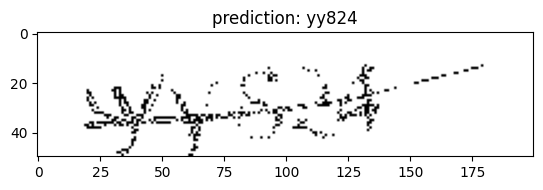

In [11]:
model.load_state_dict(torch.load("/content/drive/MyDrive/CRNN.pth", map_location=device))

with torch.no_grad():

   testset = Captcha(pth="/content/CAPTCHA/samples", train=False)
   test_img, label = testset[10]
   input_tensor = torch.unsqueeze(torch.tensor(test_img), dim=0)
   input_tensor = input_tensor.permute(0, 3, 1, 2).to(device)

   # 가장 높은 확률을 갖는 글자를 추출
   pred = torch.argmax(model(input_tensor), dim=-1)

   #  글자 간의 중복을 제거
   prev_letter = pred[0].item()
   pred_word = ""
   for letter in pred:
       if letter.item() != 0 and letter.item() != prev_letter:
           pred_word += list(testset.BOW.keys())[letter.item()]
       prev_letter = letter.item()

   plt.imshow(test_img)
   plt.title("prediction: "+pred_word)
   plt.show()